# Описание проекта

Сеть фитнес-центров **_«Культурист-датасаентист»_** разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами **_«Культурист-датасаентист»_** перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

# Данные клиента за предыдущий до проверки факта оттока месяц:

- **'gender'** — пол;
- **'Near_Location'** — проживание или работа в районе, где находится фитнес-центр;
- **'Partner'** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- **'Age'** — возраст;
- **'Lifetime'** — время с момента первого обращения в фитнес-центр (в месяцах). 

# Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- **'Contract_period'** — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- **'Month_to_end_contract'** — срок до окончания текущего действующего абонемента (в месяцах);
- **'Group_visits'** — факт посещения групповых занятий;
- **'Avg_class_frequency_total'** — средняя частота посещений в неделю за все время с начала действия абонемента;
- **'Avg_class_frequency_current_month'** — средняя частота посещений в неделю за предыдущий месяц;
- **'Avg_additional_charges_total'** — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- **'Churn'** — факт оттока в текущем месяце.


## Загрузим данные

In [1]:
# Загрузим библиотеки 
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib
%matplotlib inline
#%matplotlib notebook
from __future__ import division

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


Using matplotlib backend: agg


In [2]:
df=pd.read_csv('/datasets/gym_churn.csv')
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.columns = df.columns.str.lower()
display(df.info())
display()
display ('Кол-во пропусков:{}\n'.format(df.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

None

'Кол-во пропусков:0\n'

In [4]:
df.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Вывод**: 

Пропусков нет, дубликатов нет. Все навзание столбцов привели к нижнему регистру.



## Проведите исследовательский анализ данных (EDA)


### Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения. 

In [5]:
display(df.describe().T)# Изучим распределение данных и поменяем местами столбцы и строки для наглядности.

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Вывод**:
    


- Распределение по полу(gender) примерно одинаковые.
- Проживают в районе фитнес клуба(near_location)примерно 85% от всех посетителей.
- Сотрудники партнёр клуба (partner) составляют почти половину (48%) от всех посетителей.
- Промо-код "приведи друга" используют 30% наших посетителей.
- У большинства клиентов (90%) есть контактный телефон(phone.
- Средний жизненный цикл клиента (contract_period) составляет 4.68 месяца.
- Групповые занятия(group_visits ) посещали 41% клиентов.
- Средний возраст клиентов(age) 29 лет. Максимальный 41 год, а минимальный 18 лет.
- Средняя суммарная выручка от сопутствующих продаж в фитнесе (avg_additional_charges_total) состаявляет ~147.
- Cрок до окончания текущего действующего абонемента (month_to_end_contract ) в среднем у клиентов 4,32 месяца.
- Время с момента первого посещения фитнеса (lifetime) в среднем 3.72 месяца.
- Cредняя частота посещений в неделю за все время с начала действия абонемента(avg_class_frequency_total)- 1.88.
- Cредняя частота посещений в неделю за предыдущий месяц (avg_class_frequency_current_month) — 1,76.
- Доля оттока (churn) 26.5%.

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [6]:
group_churn=df.groupby('churn').mean()
group_churn_rotate=group_churn.T
group_churn_rotate.columns = ['остался', 'ушел']
display(group_churn_rotate)


,остался,ушел
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Вывод**:

- Пол не имеет значения.
- Больше остаются посетители, которые находятся либо живут, либо работают в том же районе, что и фитнес.
- Больше остаются посетители, которые пришли по партнерской программе.
- Больше остаются посетители,которые пришли по акции "приведи друга" .
- Наличе в базе телефона клиента не влияет на его решение остаться или покинуть клуб.
- Средняя длительность Договора больше у посетителей, которые не перестали ходить.
- Посетители, которые пользуются групповыми занятиями чаще не бросают спорт.
- Средний возраст оставшихся посетителей 30 лет, а ушедших в отток 27 лет.
- Выручка от сопутствующих продаж больше от пользователей которые не перестали ходить. Но как мы видим, разница не такая и большая.
- Время с первого посещения для посетителей, которые не перестали ходить в фитнес, гораздо больше.
- Клиенты, которые продолжают посещать зал приходят 2 раза в неделю, а те кто бросают занятия всего 1 раз.

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [7]:
#group_churn_rotate=group_churn.T
#group_churn_rotate.plot(kind='barh',figsize=(15, 10), fontsize=15)
#plt.show()

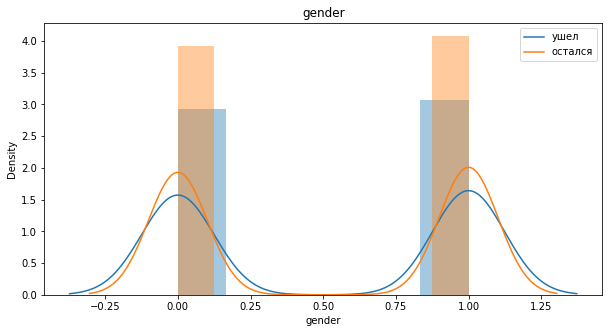

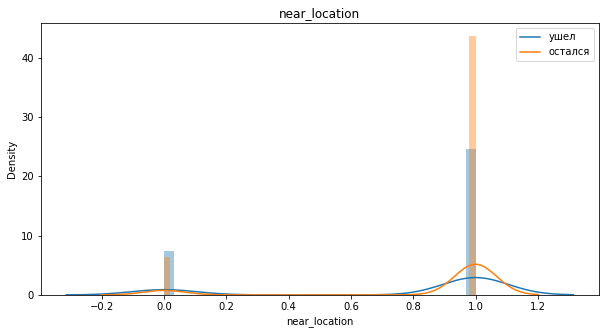

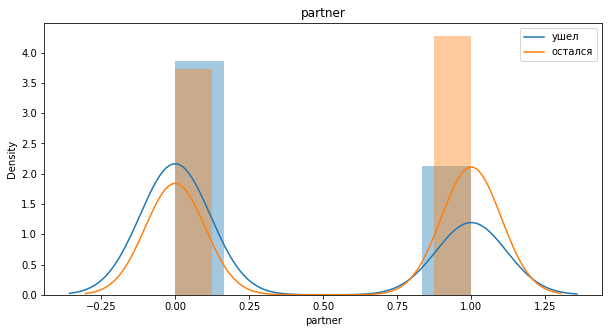

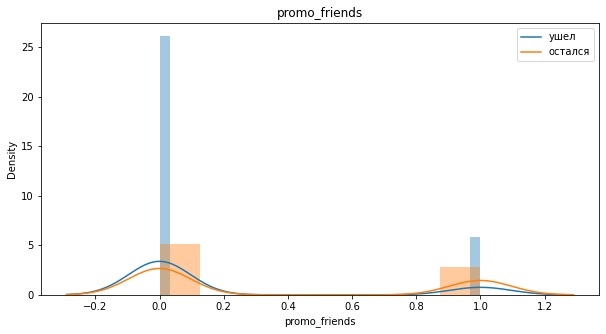

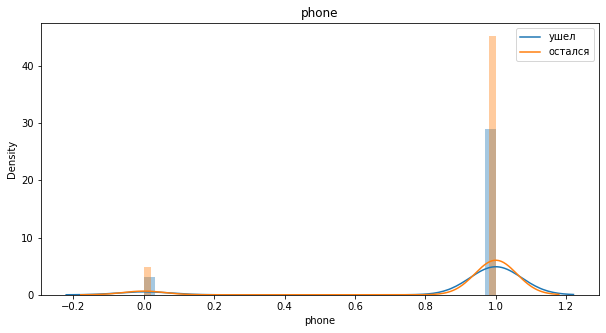

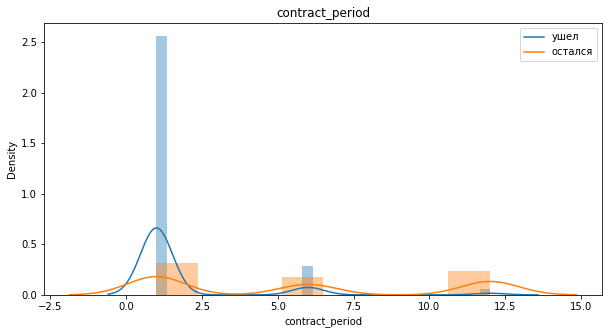

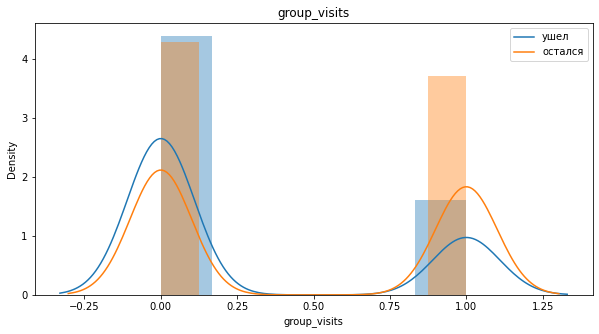

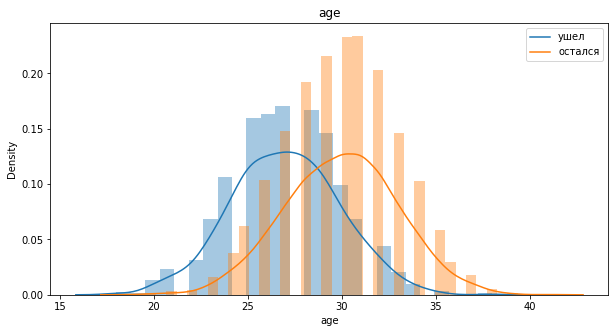

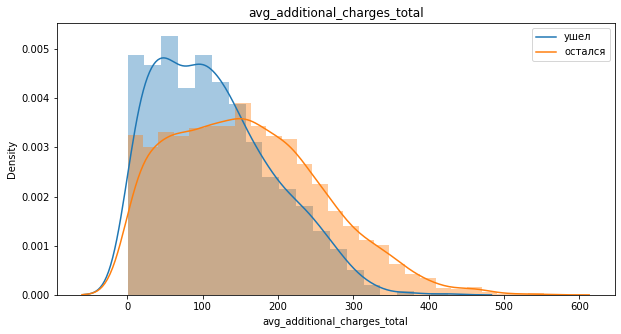

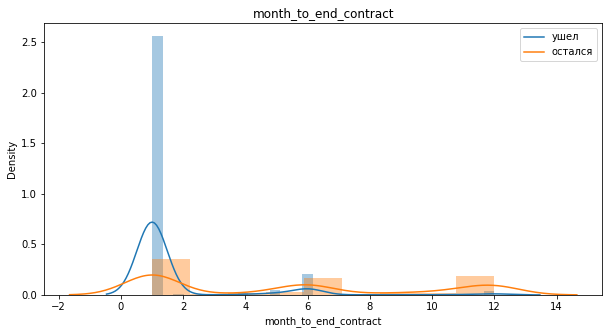

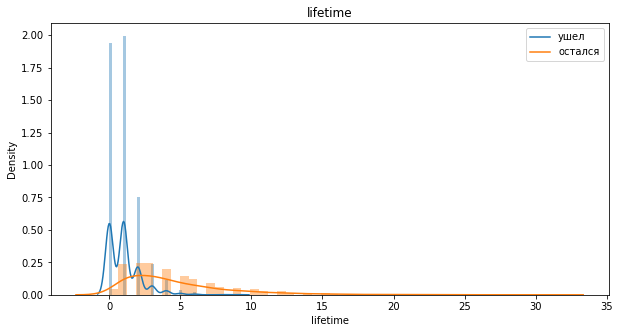

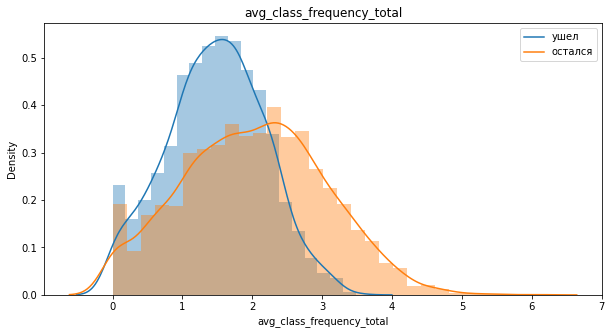

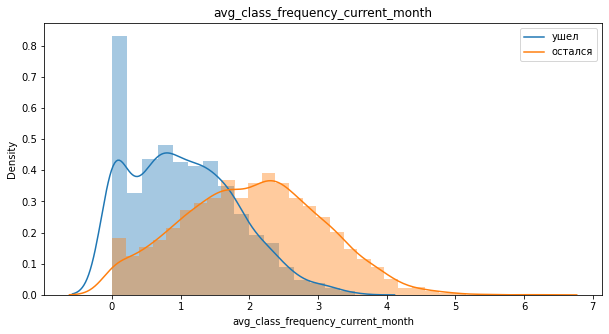

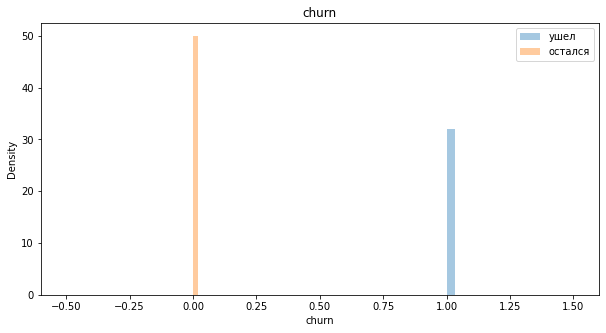

In [8]:
left = df[df['churn']==1]
stay = df[df['churn']==0]

for i in df.columns:
    plt.figure(figsize=(10, 5))
    #df.groupby('churn')[i]
    sns.distplot(left[i])
    sns.distplot(stay[i])
    plt.legend(['ушел', 'остался'])
    plt.title(i)
    plt.show()

### Построим матрицу корреляций и отобразите её.


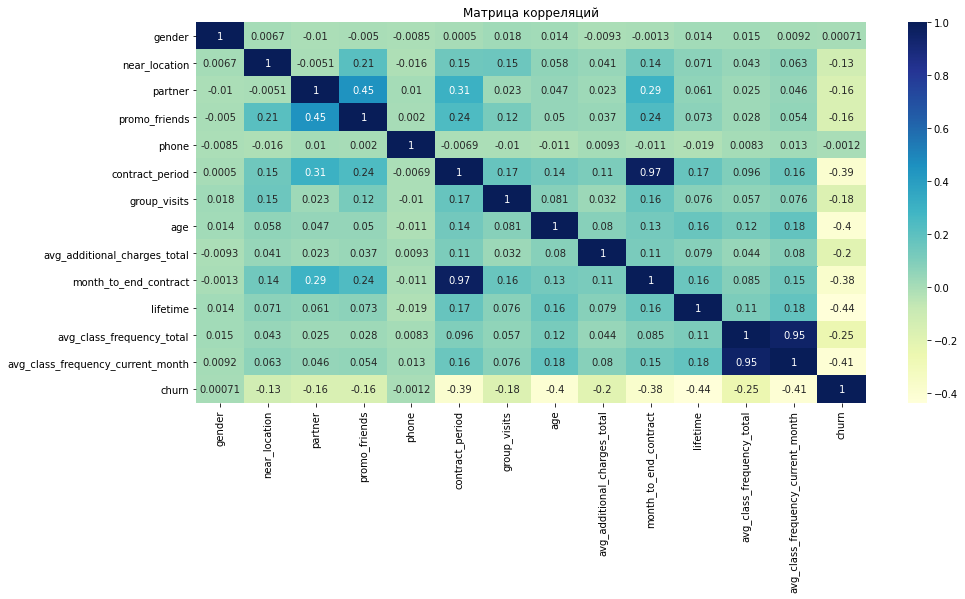

In [9]:
corr=df.corr() # Матрица корреляции для всего датафрейма.
plt.figure(figsize=(15,7))
sns.heatmap(corr, annot = True,square=False, cmap="YlGnBu")
plt.title('Матрица корреляций')
plt.xticks(rotation= 90)
plt.show()

**Вывод**

В целом мы видим небольшую общую корреляцию. Но при этом мы дожны так же отметить высоку корреляцию (данные связаны так, что когда один показатель растет, при этом растет и другой показатель)
- Contract_period(длительность абонемента) и  Month_to_end_contract(срок до окончания абонемена)0,97.Вобщем все логично.
- Между Promo_friends (сотрудникми компаний -парнеров клуба) и Partner( промо акции "приведи друга")0,45. Зеачит многие посетитилеи из компаний партнеров привели своих коллег.
- Между Partner( промо акции "приведи друга") и Contract_period(длительность абонемента)0,31. Те кто пришел по акции, берут более длительные абонементы.

Также мы наблюдаем высокую обратную корреляцию(данные связаны так, что когда один показатель растет, при этом  другой показатель падает)
- churn (отток) обратно пропорцтонален lifetime(время с первого посещения). Т.е чем дольше клиен ходит в фитнес, тем меньше вероятности, что он его покинет -0,44.
- churn (отток) обратно пропорционален age(возраст). Т.е чем младше клиент, тем более вероятно, что он бросит ходить в зал.-0,4
- churn (отток) обратно пропорционален Contract_period(длительность абонемента). Т.е. чем больше срок действия абонемента, тем менее вероятно, что клиент захочет забросить спорт или уйти к конкуренту.- 0,39.
 

## Построим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

### Разобъем данные на обучающую и валидационную выборку функцией train_test_split()

In [10]:
X = df.drop('churn', axis = 1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

### Обучите модель на train-выборке двумя способами( логистической регрессией и - случайным лесом) Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.

In [11]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]
display ('Логистическая регрессия')
display('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
display('F1: {:.2f}'.format(f1_score(y_test, predictions)))


'Логистическая регрессия'

'Accuracy: 0.92'

'Precision: 0.89'

'Recall: 0.81'

'F1: 0.85'

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
display ('Случайный лес')
display('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))


'Случайный лес'

'Accuracy: 0.92'

'Precision: 0.88'

'Recall: 0.83'

F1: 0.85


**Вывод**

**_Accuracy_** -доля правильных ответов алгоритма

для Логистическая регрессия: 0.91

для случайный лес:  0.92

**_Precision_** -точность.

для Логистическая регрессия: 0.82

для случайный лес:  0.84

**_Recall_**-полнота.

для Логистическая регрессия: 0.80

для случайный лес:  0.81

**_F1_** метрика объеднинющая точность и полноту

для Логистическая регрессия: 0.85

для случайный лес:  0.85

В целом показатели схожие, но при этом регрессия выглядит чуть хуже.

## Сделаем кластеризацию клиентов

### Стандартизируем данные. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

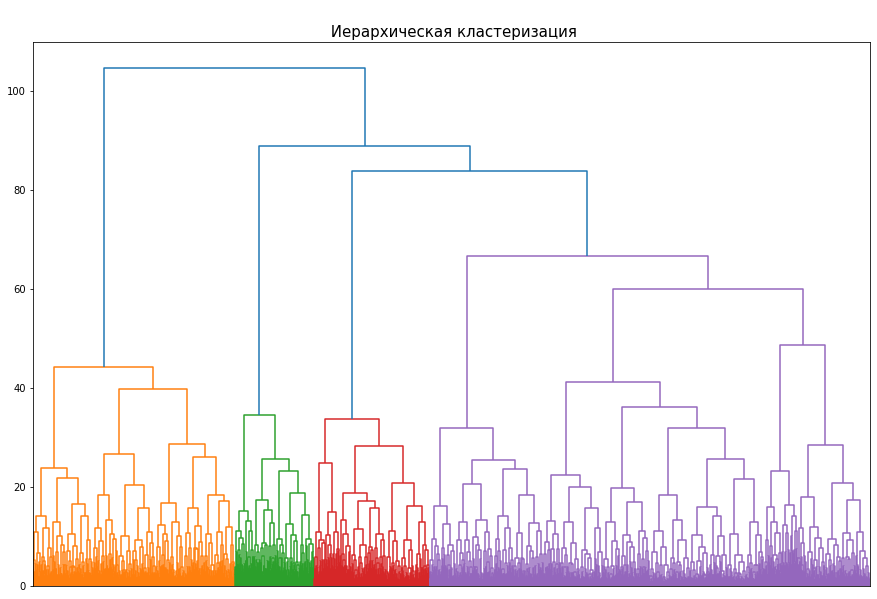

In [13]:
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top', no_labels=True)
plt.title('\n Иерархическая кластеризация', fontsize=15)
plt.show()

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы наши результаты можно было сравнивать с результатами остальных студентов. 

In [14]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_st)
df['cluster'] = labels

### Посмотрим на средние значения признаков для кластеров. Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?


In [15]:
clusters = df.groupby(['cluster']).mean()
display(clusters.T)


cluster,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


In [16]:
#plt.figure(figsize=(14, 10))
#sns.heatmap(clusters.T, annot = True, fmt = '0.2f', linewidths=.5, cmap="YlGnBu")
#plt.show()

<Figure size 1080x1080 with 0 Axes>

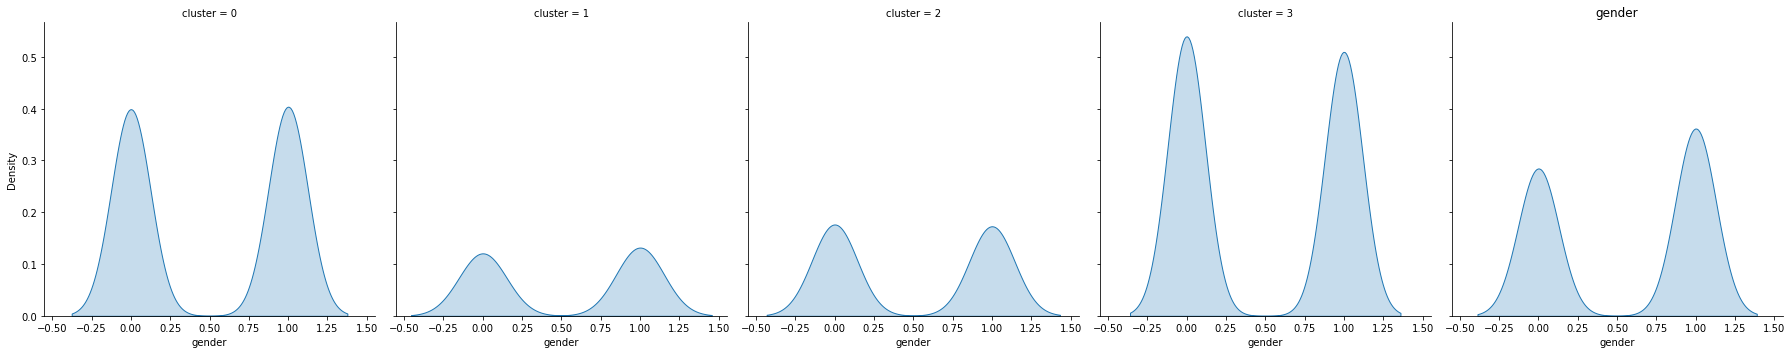

<Figure size 1080x1080 with 0 Axes>

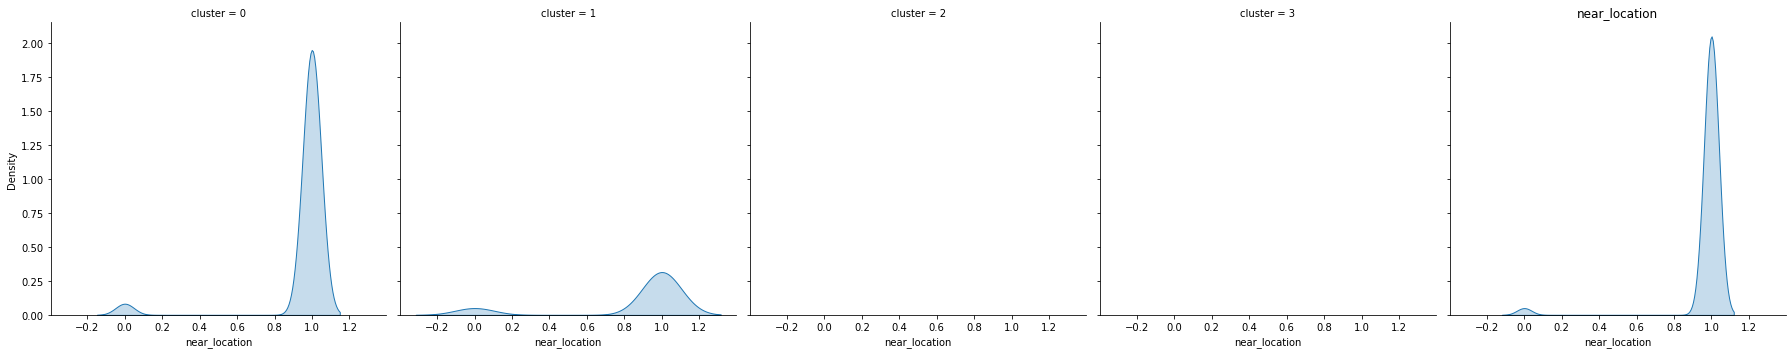

<Figure size 1080x1080 with 0 Axes>

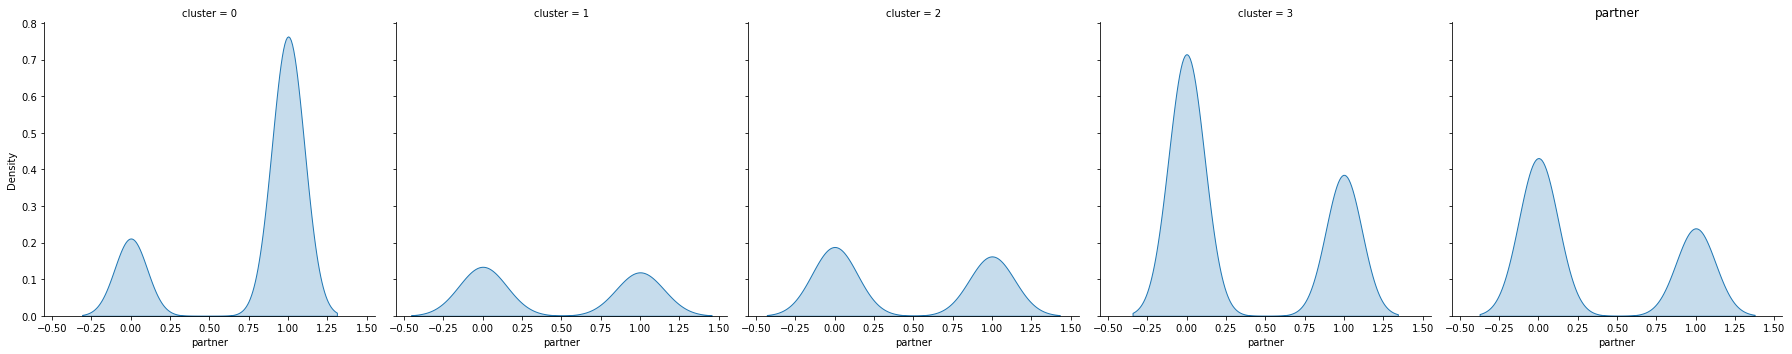

<Figure size 1080x1080 with 0 Axes>

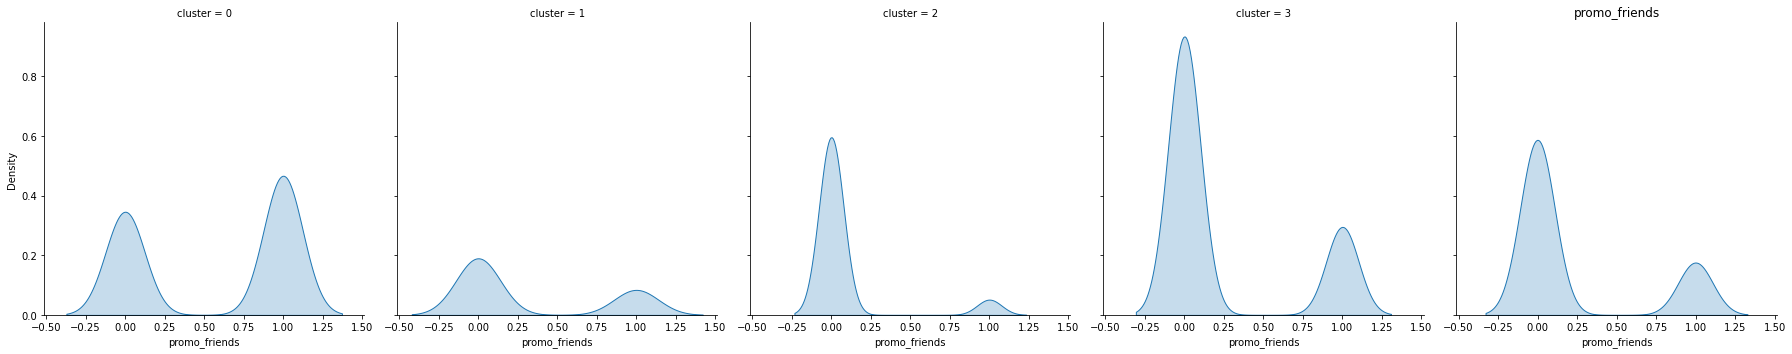

<Figure size 1080x1080 with 0 Axes>

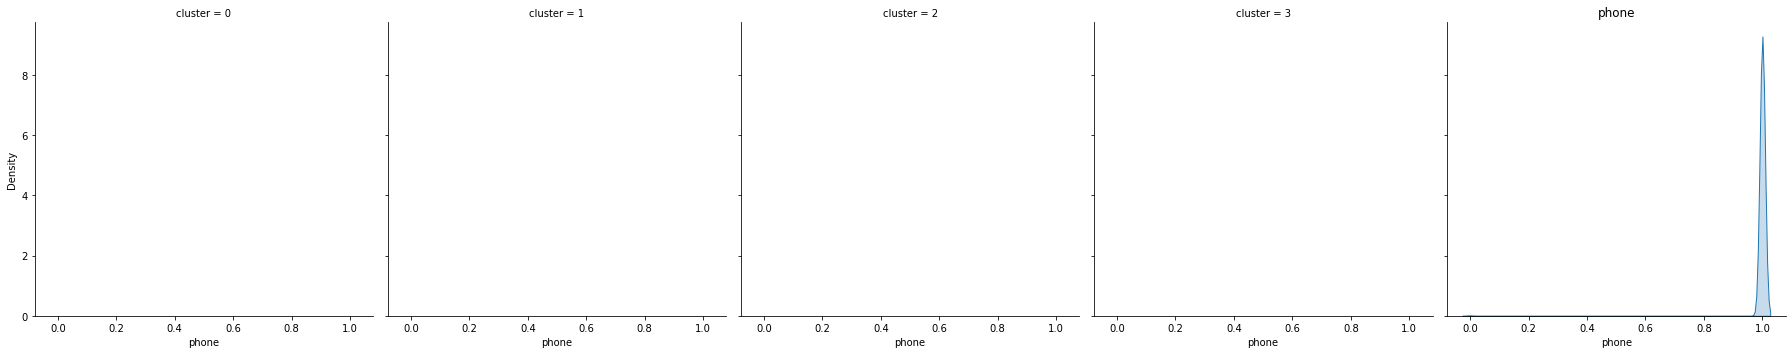

<Figure size 1080x1080 with 0 Axes>

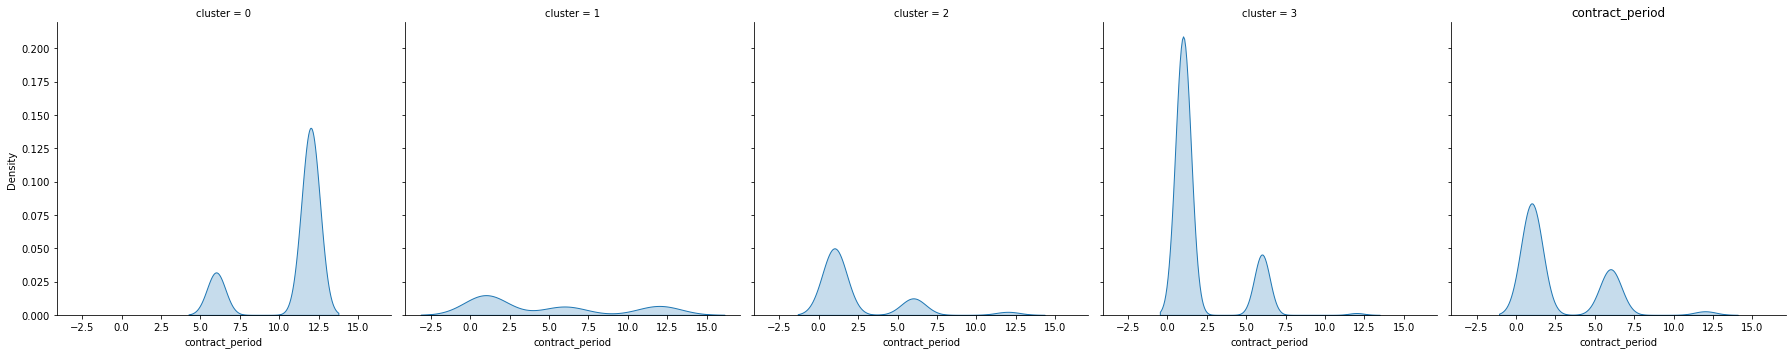

<Figure size 1080x1080 with 0 Axes>

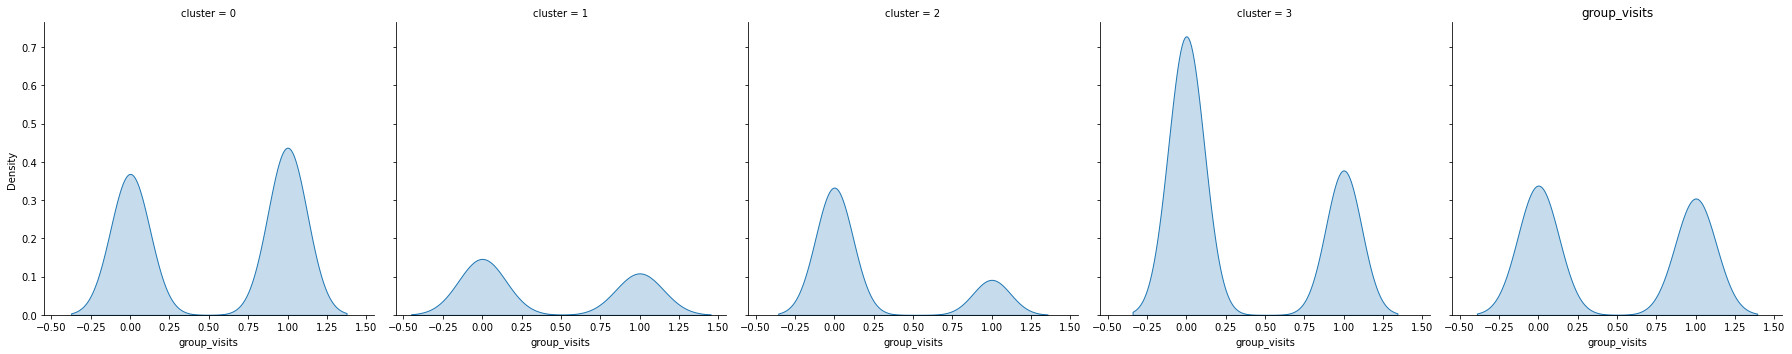

<Figure size 1080x1080 with 0 Axes>

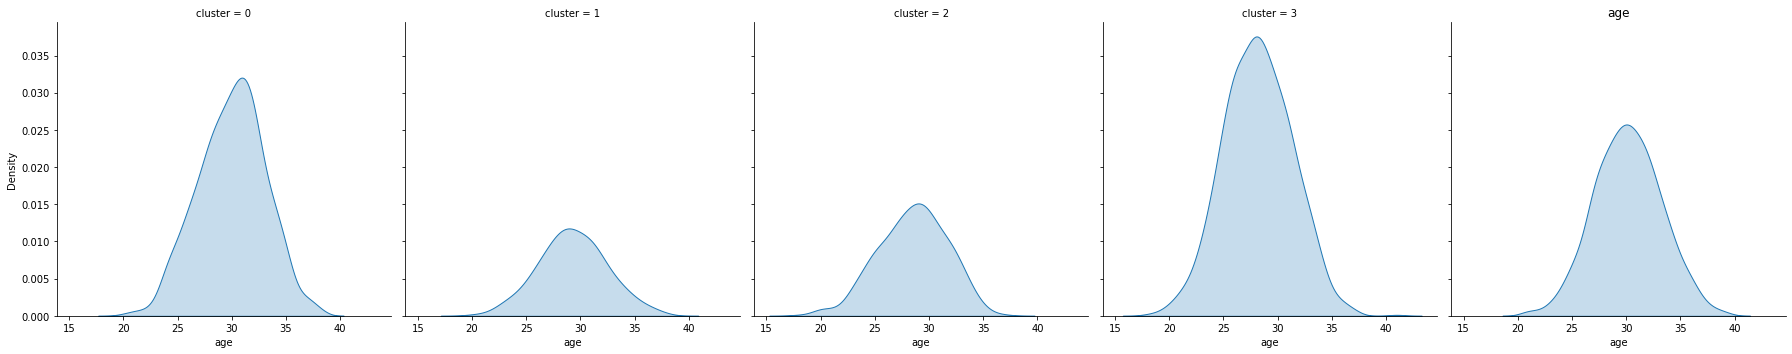

<Figure size 1080x1080 with 0 Axes>

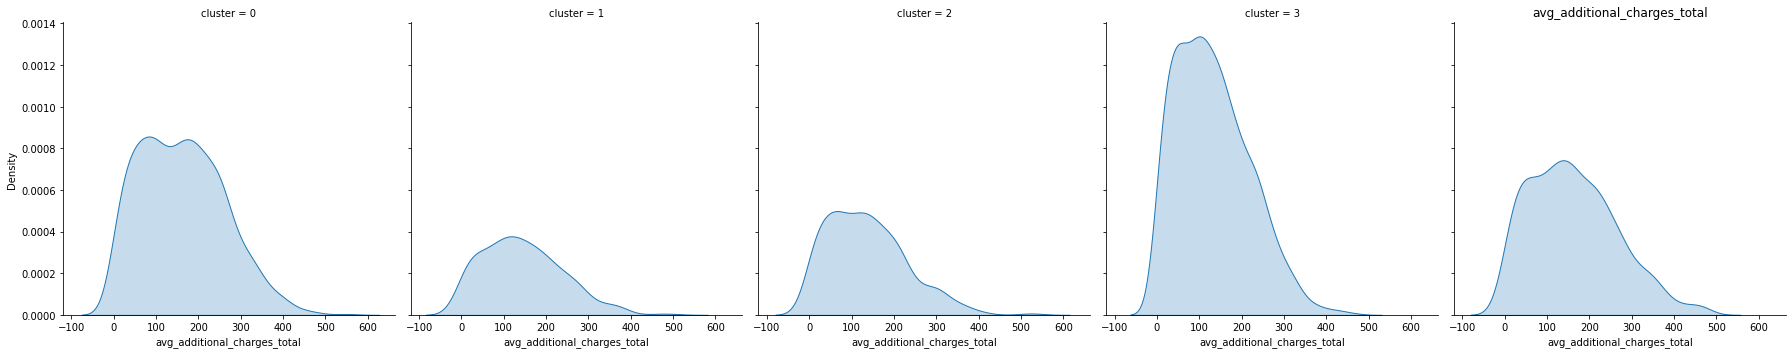

<Figure size 1080x1080 with 0 Axes>

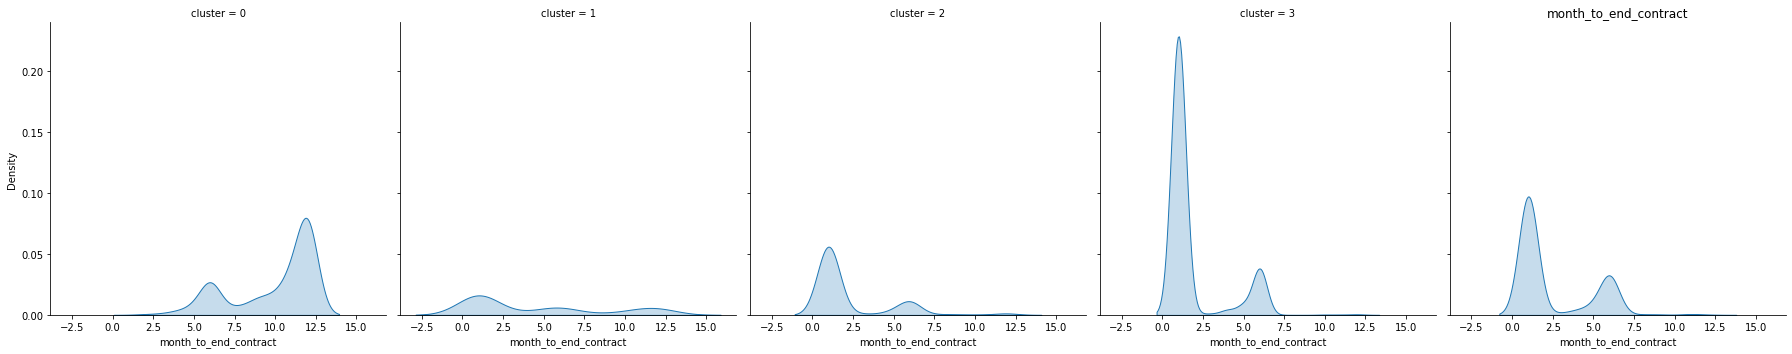

<Figure size 1080x1080 with 0 Axes>

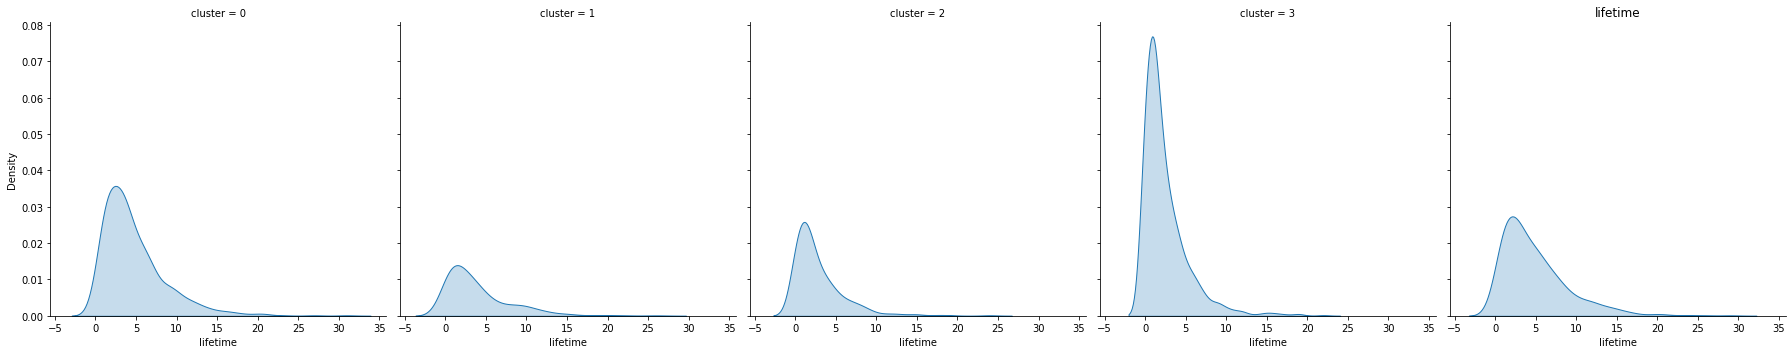

<Figure size 1080x1080 with 0 Axes>

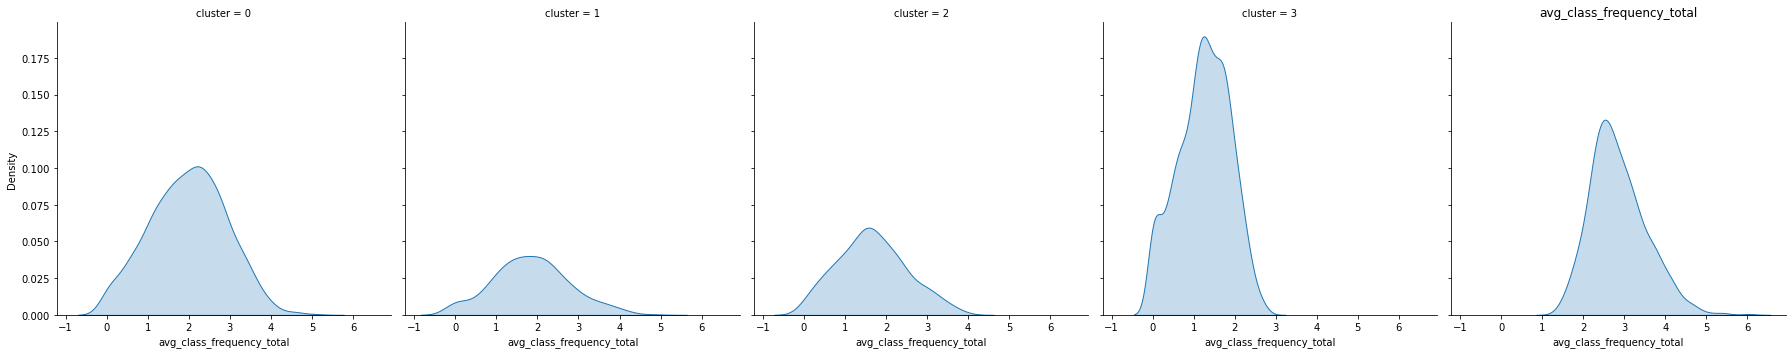

<Figure size 1080x1080 with 0 Axes>

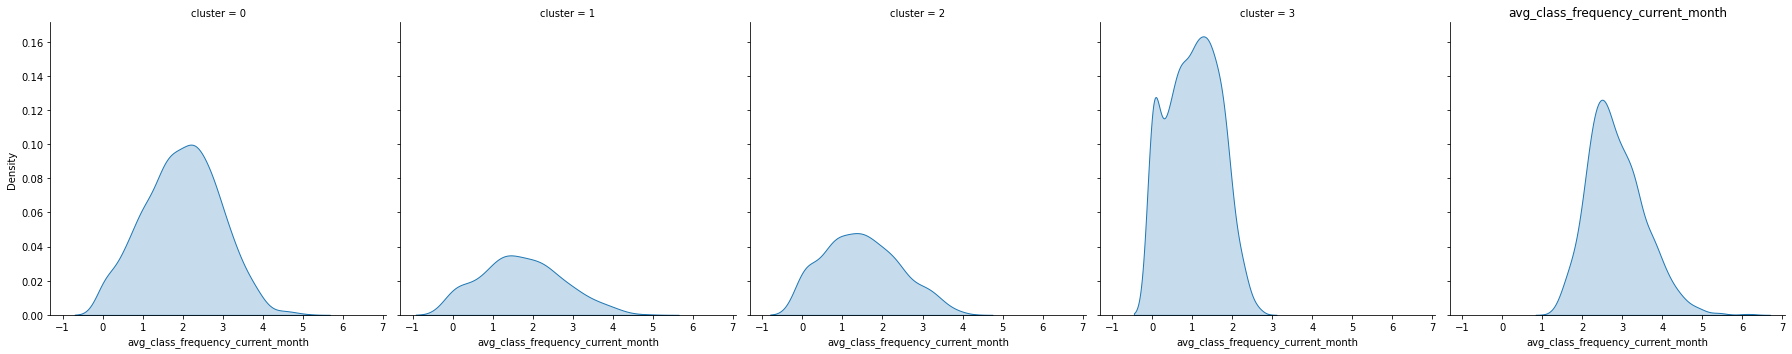

<Figure size 1080x1080 with 0 Axes>

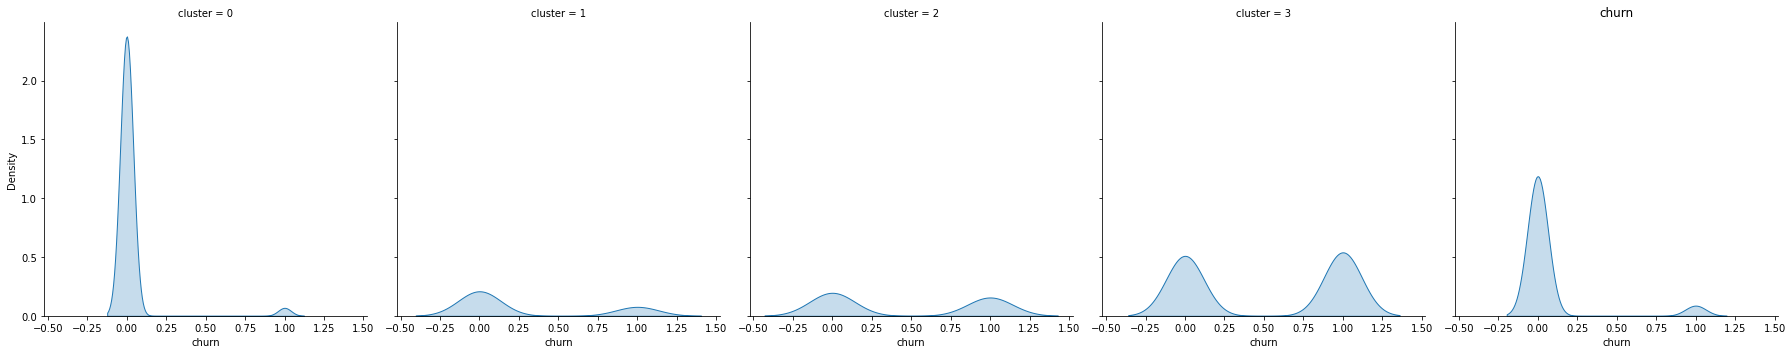

<Figure size 1080x1080 with 0 Axes>

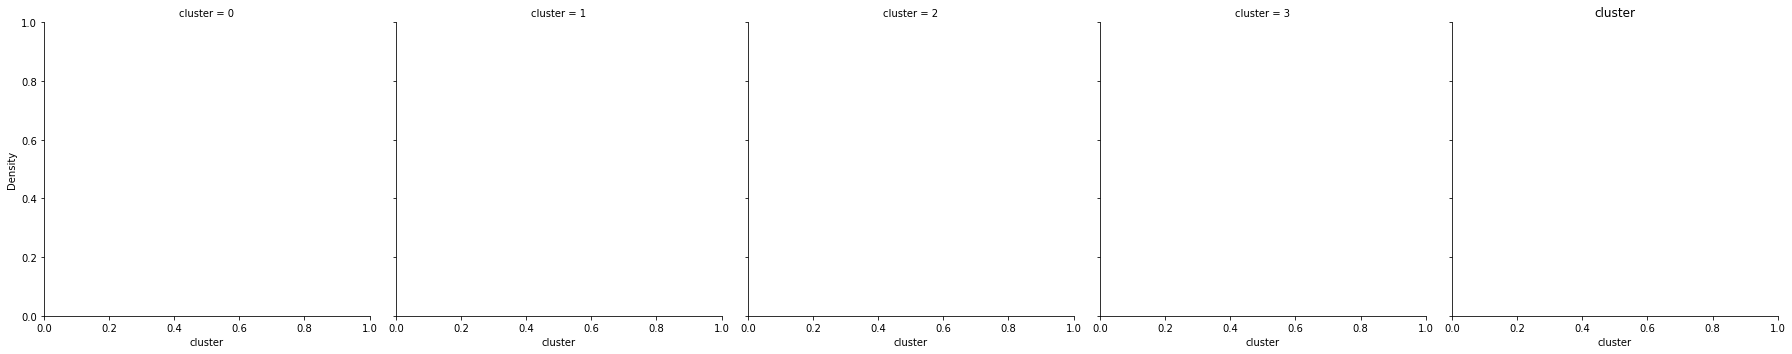

In [17]:
for column in df:
    plt.figure(figsize=(15, 15))
    sns.displot(x = df[column],col='cluster', kind="kde", fill=True, data=df)
    #sns.countplot(x = df[column], hue='cluster', data=df)
    plt.title(column)
    plt.show()

In [18]:
clusters_ch = df.groupby(['cluster']).mean()['churn']
procent =(clusters_ch*100).round().map("{:.2f}%".format)
display(procent)


cluster
0     3.00%
1    27.00%
2    44.00%
3    51.00%
4     7.00%
Name: churn, dtype: object

 ## Сформулируем выводы и сделайте базовые рекомендации по работе с клиентами

**Вывод:**

- **_Кластер 0_**

  Отток - 3%.
  
  Большое кол-во клиентов из района где находится фитнес.
  
  Большое кол-во клиентов пришли из партнерских компаний.
  
  Самое большое использолвание промо-кода.
  
  Самый большой срок абонементов ~ 11 месяцев.
  
  Самое большое кол-во месяцев до конца контракта - 9.95 месяца.
  
  Много тратят на сопутсвующие товары ~161.
  
  Посещяют почти 2 раза в неделю.  


- **_Клаcтер 1_**

     Отток - 27%.
     
     Похож на **_Кластер 0_**, но все показатели  чуть ниже.
     
     При этом длительность абонемента ниже чем **_Кластер 0_** больше чем в  2 раза.~5 месяцев.
     


- **_Клаcтер 2_**
     
     Отток 44%.
     
     Все клиенты не из района где находится фитнес.
     
     Все показатели низкие, при этом кол-во сотрудников компаний партнеров такое же как в **_Клаcтер 2_**.
     

- **_Клаcтер 3_**
     
     Отток 51%.
     
     Все клиенты из нашего района.
     
     Самые большой отток и самые низкие показатели.
     
     Ходяд раз в неделю, т.е в 2 раза меньше чем **_Кластер 0_**, при этом денег тратят всего на 19% меньше.
     

- **_Клаcтер 4_**

    
     Отток 7%.
     
     Чаще всех ходят.
     
     Больше всех тратят.
     
     Меньше всех используют промо-код.
     
     Но при этом абонименты короткие. Всего ~ 3 месяца.  

**Рекомендации**:
    
- Необходимо выстроить модель аналитики так, чтобы предвидеть отток.

- Дополнительные промоакции для жителей района в котором находится фитнес-клуб. Акция приведи друга не всегда хорошо работает.

- Мотивировать клиентов покупать более длительные абонементны.

- Увеличить ассортимент сопутствующих товаров, их хорошо покупают и те кто ходят часто и те кто ходят редко.

    
    